Zestimate Home занимаются оценкой стоимости недвижимости.
«Zestimates» - это оценочные значения стоимости дома, основанные на 7,5 миллионах статистических моделей и моделей машинного обучения, которые анализируют сотни точек данных по каждому объекту недвижимости. 

Есть данные об ошибке их прогноза

𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟 = 𝑙𝑜𝑔 (𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒) −𝑙𝑜𝑔 (𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒)

Мы хотим спрогнозировать logerror.



<h1> Будем проверять гипотезу о связи плотности участков </h1>

Высокая плотность участков указывает на большое количество точек данных в его географическом регионе. Эта `` плотность '' вокруг участка может быть связана с прогнозируемой нами логической ошибкой, поскольку производительность модели (т.е. логарифмическая ошибка) обычно зависит от количества репрезентативных данных, на которых она была обучена. Поэтому проверим следующую гипотезу:

<h3> Гипотеза: более высокая плотность участков связана с меньшей абсолютной логической ошибкой. </h3>
<p> </p>
<p> </p>


Давайте начнем!


<h1> 1. Импорт </h1>
Сначала импортируем нужные нам пакеты. Затем мы импортируем данные. Поскольку мы хотим знать взаимосвязь между логарифмической ошибкой и плотностью участков, для анализа нам нужны только строки из обучающего набора, содержащие координаты x, y. К остальным данным вернемся позже.

In [197]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats.stats import pearsonr
from scipy.stats import rankdata


In [176]:
train = pd.read_csv('train_2016_v2.csv')
props = pd.read_csv('properties_2016.csv',low_memory=False)
train_ = train.merge(props,how='left',on='parcelid')
train_.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [177]:
train = train_[['parcelid','longitude','latitude','logerror']]
train.dropna(inplace=True) 
display(train.head())
print("shape = ",train.shape)

<ipython-input-177-490968f30ff4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


,parcelid,longitude,latitude,logerror
0,11016594,-118488536.0,34280990.0,0.0276
1,14366692,-117677556.0,33668120.0,-0.1684
2,12098116,-118175032.0,34136312.0,-0.0040
3,12643413,-118309000.0,33755800.0,0.0218
4,14432541,-117700234.0,33485643.0,-0.0050


shape =  (90275, 4)


<h1> 2. Восстановление распределения</h1>

«Оценка ядерной плотности» или KDE. Он оценивает функцию плотности вероятности по заданным точкам данных. В нашем случае эти точки данных являются географическими координатами участков.



Будем использовать гауссовское ядро.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Kernel_density.svg/250px-Kernel_density.svg.png)

Для оптимизации  производительности  функции я уже задала некоторые параметры для KDTree

In [188]:
def get_pde(train,bw):
    x = train['longitude'].values
    y = train['latitude'].values
    xy = np.vstack([x,y])
    X = np.transpose(xy)
    #tree = KDTree(X,leaf_size = 20 )     
    #parcelDensity = tree.kernel_density(X, h=bw,kernel='gaussian',rtol=0.00001)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw,rtol=0.00001).fit(X)
    parcelDensity = kde.score_samples(X)
    return parcelDensity

In [189]:
parcelDensity30000 = get_pde(train,30000)
parcelDensity1000 = get_pde(train,1000)
parcelDensity300 = get_pde(train,300)


<h3> 2.1 Визуализация плотности участков с шириной окна 30 000 </h3>
Давайте визуализируем результаты нашего KDE в виде диаграммы разброса. Мы используем долготу и широту наших участков как координаты x, y и раскрашиваем эти точки по их плотности. На графике четко показаны наиболее плотные области ярко-желтым цветом, более полуцентральные участки - оранжевым, периферийные участки - фиолетовым, а относительно изолированные места - черным.

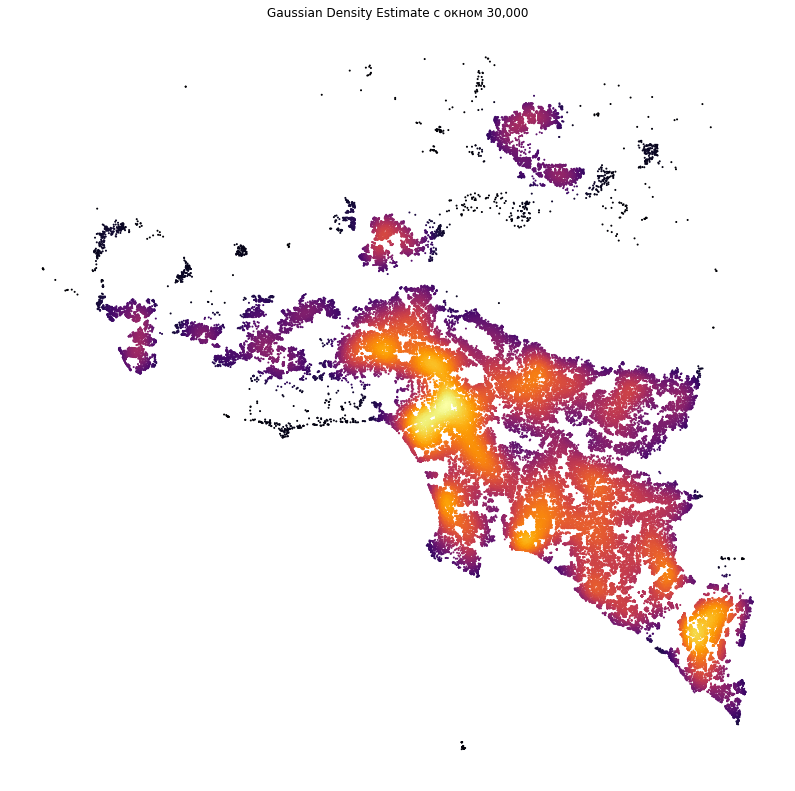

In [119]:
plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Gaussian Density Estimate с окном 30,000")
plt.scatter(x=train['longitude'].values, y=train['latitude'].values, c=parcelDensity30000,cmap='inferno', s=1)


Ярко-желтая плотная область на карте почти идеально сочетается с тем, что Google Maps определяет как центр Лос-Анджелеса. Это означает, что функция плотности участков теперь содержит информацию о центральности определенного участка. 
https://www.google.nl/maps/place/Downtown,+Los+Angeles,+CA,+USA/@33.9761623,-118.5305526,10z/data=!4m5!3m4!1s0x80c2c634253dfd01:0x26fe52df19a5a920!8m2!3d34.040713!4d-118.2467693 

<h3> 2.2 Визуализация плотности участков с шириной окна 1000 и 300 </h3>
В KDE с меньшим размером окна локальные колебания относительно сильны и не могут вызвать выбросы, которые превосходят «нормальные» колебания в KDE на изображении графика. Чтобы улучшить видимость умеренных колебаний, оценим KDE для этих графиков по их процентилям.

In [191]:
rankScaled30000 = 100*rankdata(parcelDensity30000)/len(parcelDensity30000)
rankScaled1000 = 100*rankdata(parcelDensity1000)/len(parcelDensity1000)
rankScaled300 = 100*rankdata(parcelDensity300)/len(parcelDensity300)

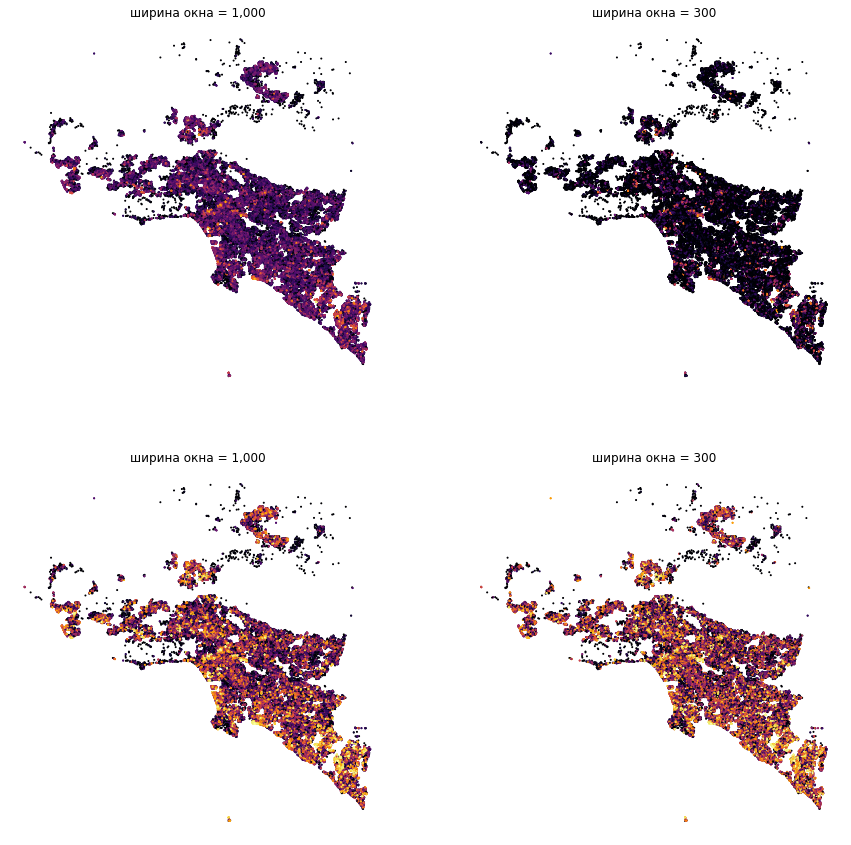

In [192]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(221)
ax1.set_title('ширина окна = 1,000')
ax1.set_axis_off()
ax1.scatter(train['longitude'].values, train['latitude'].values, c=parcelDensity1000,cmap='inferno', s=1)

ax2 = fig.add_subplot(222)
ax2.set_title('ширина окна = 300')
ax2.set_axis_off()
ax2.scatter(train['longitude'].values, train['latitude'].values, c=parcelDensity300,cmap='inferno', s=1)


ax3 = fig.add_subplot(223)
ax3.set_title('ширина окна = 1,000')
ax3.set_axis_off()
ax3.scatter(train['longitude'].values, train['latitude'].values, c=rankScaled1000,cmap='inferno', s=1)

ax4 = fig.add_subplot(224)
ax4.set_title('ширина окна = 300')
ax4.set_axis_off()
ax4.scatter(train['longitude'].values, train['latitude'].values, c=rankScaled300,cmap='inferno', s=1)



<h1> 3. Результаты </h1>
Мы хотим проверить, связаны ли более высокие значения KDE с более низкими абсолютными ошибками. Поэтому мы хотим сравнить KDE с абсолютной ошибкой logerror. Измерим корреляцию Пирсона для 3 размеров окна.

<h3> 3.1 Результат окна 30 000 </h3>
подробно рассмотрим результаты для окна 30 000.

In [133]:
abs_logerrors = np.abs(train['logerror'].values)

In [174]:
corrCoef_30000, _ = pearsonr(parcelDensity30000,abs_logerrors)

print("Результат для окна 30,000:", corrCoef_30000)

Результат для окна 30,000: 0.009403149226511672


нет значимой отрицательной корреляции между функцией плотности и абсолютной логической ошибкой с окном 30 000


<h3> 3.2 Результаты для окон 1000 и 300 </h3>


In [196]:
corrCoef_1000, _ = pearsonr(parcelDensity1000,abs_logerrors)
corrCoef_300, _ = pearsonr(parcelDensity300,abs_logerrors)

print("для окна 1,000, Correlation Coefficient: ",corrCoef_1000)
print()
print("для окна 500, Correlation Coefficient: ",corrCoef_300)




для окна 1,000, Correlation Coefficient:  -0.05989955318105651

для окна 500, Correlation Coefficient:  -0.04604267329502189


для 1,000 и 300 существует значительная отрицательная корреляция между KDE и абсолютной логической ошибкой.


<h1> 4. Заключение </h1>
Результат показывает, что более высокая плотность связана с меньшими абсолютными ошибками. Эта гипотеза подтвердилась для окон 1000 и 300. Неожиданно противоположная зависимость наблюдалась для  30 000. В целом, это означает, что плотность участков может быть полезным признаком для прогнозирования логической ошибки Zestimate и ее добавление может значительно улучшить результаты предсказаний, и на примере Zestimate, поможет им делать более точные прогнозы.


In [45]:
cat_features = [i for i in train_.columns if train_[i].dtype !='float64']
cat_features

['parcelid',
 'transactiondate',
 'hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'taxdelinquencyflag']

In [78]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(cat_features=cat_features, iterations=200, random_state=42)

X = train_.drop(['logerror'], axis = 1)
X[cat_features] = X[cat_features].fillna("")
y = train_['logerror']*100
scores = -np.mean(cross_val_score(cbr, X, y, cv=3, scoring='neg_mean_absolute_error'))
scores

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.27502
0:	learn: 15.2683366	total: 34.9ms	remaining: 6.94s
1:	learn: 15.2427836	total: 67.4ms	remaining: 6.67s
2:	learn: 15.2283098	total: 91ms	remaining: 5.97s
3:	learn: 15.2065057	total: 124ms	remaining: 6.08s
4:	learn: 15.1918173	total: 156ms	remaining: 6.08s
5:	learn: 15.1814828	total: 200ms	remaining: 6.47s
6:	learn: 15.1618239	total: 253ms	remaining: 6.97s
7:	learn: 15.1487828	total: 296ms	remaining: 7.11s
8:	learn: 15.1329107	total: 328ms	remaining: 6.96s
9:	learn: 15.1135230	total: 370ms	remaining: 7.03s
10:	learn: 15.1094832	total: 405ms	remaining: 6.96s
11:	learn: 15.1056500	total: 440ms	remaining: 6.9s
12:	learn: 15.0885385	total: 475ms	remaining: 6.83s
13:	learn: 15.0843395	total: 500ms	remaining: 6.64s
14:	learn: 15.0731588	total: 534ms	remaining: 6.58s
15:	learn: 15.0614316	total: 565ms	remaining: 6.49s
16:	learn: 15.0497927	total: 597ms	remaining: 6.42s
17:	learn: 15.0406157	total: 636ms	remaining: 6.43s
18:	learn: 15.0147597	total: 677ms	remaining:

158:	learn: 14.2120870	total: 5.34s	remaining: 1.38s
159:	learn: 14.2084662	total: 5.38s	remaining: 1.35s
160:	learn: 14.2039136	total: 5.42s	remaining: 1.31s
161:	learn: 14.2015090	total: 5.46s	remaining: 1.28s
162:	learn: 14.1875596	total: 5.49s	remaining: 1.25s
163:	learn: 14.1823497	total: 5.52s	remaining: 1.21s
164:	learn: 14.1782933	total: 5.56s	remaining: 1.18s
165:	learn: 14.1775002	total: 5.61s	remaining: 1.15s
166:	learn: 14.1747157	total: 5.65s	remaining: 1.12s
167:	learn: 14.1704004	total: 5.68s	remaining: 1.08s
168:	learn: 14.1655998	total: 5.71s	remaining: 1.05s
169:	learn: 14.1614384	total: 5.74s	remaining: 1.01s
170:	learn: 14.1613077	total: 5.77s	remaining: 978ms
171:	learn: 14.1612186	total: 5.8s	remaining: 945ms
172:	learn: 14.1580431	total: 5.85s	remaining: 912ms
173:	learn: 14.1559457	total: 5.89s	remaining: 880ms
174:	learn: 14.1508427	total: 5.93s	remaining: 847ms
175:	learn: 14.1485155	total: 5.97s	remaining: 815ms
176:	learn: 14.1438381	total: 6.01s	remaining: 

115:	learn: 15.7156067	total: 4.34s	remaining: 3.14s
116:	learn: 15.7103159	total: 4.37s	remaining: 3.1s
117:	learn: 15.7020077	total: 4.4s	remaining: 3.06s
118:	learn: 15.7017525	total: 4.43s	remaining: 3.02s
119:	learn: 15.6994717	total: 4.46s	remaining: 2.97s
120:	learn: 15.6950368	total: 4.49s	remaining: 2.93s
121:	learn: 15.6897706	total: 4.52s	remaining: 2.89s
122:	learn: 15.6879566	total: 4.57s	remaining: 2.86s
123:	learn: 15.6851009	total: 4.61s	remaining: 2.82s
124:	learn: 15.6750415	total: 4.63s	remaining: 2.78s
125:	learn: 15.6734937	total: 4.66s	remaining: 2.74s
126:	learn: 15.6731769	total: 4.69s	remaining: 2.7s
127:	learn: 15.6652848	total: 4.74s	remaining: 2.66s
128:	learn: 15.6583617	total: 4.77s	remaining: 2.63s
129:	learn: 15.6577543	total: 4.82s	remaining: 2.6s
130:	learn: 15.6533490	total: 4.87s	remaining: 2.56s
131:	learn: 15.6472527	total: 4.91s	remaining: 2.53s
132:	learn: 15.6420046	total: 4.95s	remaining: 2.49s
133:	learn: 15.6354459	total: 4.99s	remaining: 2.4

73:	learn: 15.6807661	total: 2.34s	remaining: 3.99s
74:	learn: 15.6747790	total: 2.38s	remaining: 3.97s
75:	learn: 15.6700027	total: 2.42s	remaining: 3.95s
76:	learn: 15.6694680	total: 2.46s	remaining: 3.93s
77:	learn: 15.6577266	total: 2.5s	remaining: 3.9s
78:	learn: 15.6561664	total: 2.54s	remaining: 3.89s
79:	learn: 15.6519617	total: 2.58s	remaining: 3.87s
80:	learn: 15.6470938	total: 2.62s	remaining: 3.85s
81:	learn: 15.6435680	total: 2.67s	remaining: 3.83s
82:	learn: 15.6431791	total: 2.7s	remaining: 3.8s
83:	learn: 15.6396764	total: 2.72s	remaining: 3.76s
84:	learn: 15.6268610	total: 2.75s	remaining: 3.73s
85:	learn: 15.6265648	total: 2.79s	remaining: 3.7s
86:	learn: 15.6197743	total: 2.83s	remaining: 3.68s
87:	learn: 15.6103261	total: 2.87s	remaining: 3.66s
88:	learn: 15.5979411	total: 2.91s	remaining: 3.63s
89:	learn: 15.5852238	total: 2.94s	remaining: 3.6s
90:	learn: 15.5709155	total: 2.98s	remaining: 3.56s
91:	learn: 15.5652926	total: 3.02s	remaining: 3.54s
92:	learn: 15.5580

7.070652434754578

In [79]:
scores

7.070652434754578

In [94]:
train_2 = pd.concat([train_, 
                     pd.DataFrame([parcelDensity1000,
                                   parcelDensity300]).T], 
                    axis = 1)

In [95]:
cbr = CatBoostRegressor(cat_features=cat_features, iterations=200, random_state=42)

X = train_2.drop(['logerror'], axis = 1)
X[cat_features] = X[cat_features].fillna("")
y = train_['logerror'] * 100
scores = -np.mean(cross_val_score(cbr, X, y, cv=3, scoring='neg_mean_absolute_error'))
scores

Learning rate set to 0.27502
0:	learn: 15.2688361	total: 34.6ms	remaining: 6.88s
1:	learn: 15.2477599	total: 65.7ms	remaining: 6.5s
2:	learn: 15.2305591	total: 99.4ms	remaining: 6.53s
3:	learn: 15.2068306	total: 133ms	remaining: 6.53s
4:	learn: 15.1917251	total: 168ms	remaining: 6.55s
5:	learn: 15.1788119	total: 200ms	remaining: 6.46s
6:	learn: 15.1663450	total: 241ms	remaining: 6.66s
7:	learn: 15.1521303	total: 275ms	remaining: 6.6s
8:	learn: 15.1434995	total: 315ms	remaining: 6.68s
9:	learn: 15.1353278	total: 346ms	remaining: 6.58s
10:	learn: 15.1252421	total: 386ms	remaining: 6.64s
11:	learn: 15.1100091	total: 434ms	remaining: 6.8s
12:	learn: 15.0922001	total: 472ms	remaining: 6.79s
13:	learn: 15.0858413	total: 509ms	remaining: 6.76s
14:	learn: 15.0798478	total: 551ms	remaining: 6.8s
15:	learn: 15.0745902	total: 581ms	remaining: 6.68s
16:	learn: 15.0660549	total: 617ms	remaining: 6.64s
17:	learn: 15.0616670	total: 656ms	remaining: 6.63s
18:	learn: 15.0486616	total: 693ms	remaining: 

160:	learn: 14.2398073	total: 5.72s	remaining: 1.39s
161:	learn: 14.2378402	total: 5.75s	remaining: 1.35s
162:	learn: 14.2350014	total: 5.78s	remaining: 1.31s
163:	learn: 14.2316837	total: 5.82s	remaining: 1.28s
164:	learn: 14.2277039	total: 5.85s	remaining: 1.24s
165:	learn: 14.2224762	total: 5.88s	remaining: 1.2s
166:	learn: 14.2215300	total: 5.92s	remaining: 1.17s
167:	learn: 14.2172824	total: 5.96s	remaining: 1.13s
168:	learn: 14.2084126	total: 5.99s	remaining: 1.1s
169:	learn: 14.1985328	total: 6.02s	remaining: 1.06s
170:	learn: 14.1944654	total: 6.05s	remaining: 1.03s
171:	learn: 14.1920868	total: 6.08s	remaining: 990ms
172:	learn: 14.1838159	total: 6.11s	remaining: 954ms
173:	learn: 14.1819444	total: 6.14s	remaining: 918ms
174:	learn: 14.1779402	total: 6.18s	remaining: 883ms
175:	learn: 14.1769189	total: 6.22s	remaining: 848ms
176:	learn: 14.1719451	total: 6.25s	remaining: 812ms
177:	learn: 14.1698441	total: 6.29s	remaining: 778ms
178:	learn: 14.1662196	total: 6.35s	remaining: 7

120:	learn: 15.7097728	total: 4.77s	remaining: 3.11s
121:	learn: 15.6983991	total: 4.8s	remaining: 3.07s
122:	learn: 15.6913490	total: 4.83s	remaining: 3.03s
123:	learn: 15.6903273	total: 4.87s	remaining: 2.98s
124:	learn: 15.6877123	total: 4.9s	remaining: 2.94s
125:	learn: 15.6863185	total: 4.93s	remaining: 2.9s
126:	learn: 15.6848151	total: 4.96s	remaining: 2.85s
127:	learn: 15.6831920	total: 5s	remaining: 2.81s
128:	learn: 15.6792113	total: 5.04s	remaining: 2.77s
129:	learn: 15.6648838	total: 5.06s	remaining: 2.73s
130:	learn: 15.6631079	total: 5.09s	remaining: 2.68s
131:	learn: 15.6558837	total: 5.12s	remaining: 2.64s
132:	learn: 15.6529584	total: 5.14s	remaining: 2.59s
133:	learn: 15.6391270	total: 5.18s	remaining: 2.55s
134:	learn: 15.6305120	total: 5.21s	remaining: 2.51s
135:	learn: 15.6266718	total: 5.24s	remaining: 2.47s
136:	learn: 15.6110593	total: 5.27s	remaining: 2.42s
137:	learn: 15.6016930	total: 5.31s	remaining: 2.38s
138:	learn: 15.5991093	total: 5.34s	remaining: 2.34s

81:	learn: 15.6132607	total: 2.59s	remaining: 3.72s
82:	learn: 15.6102232	total: 2.63s	remaining: 3.71s
83:	learn: 15.6036657	total: 2.66s	remaining: 3.68s
84:	learn: 15.5955030	total: 2.7s	remaining: 3.65s
85:	learn: 15.5784008	total: 2.73s	remaining: 3.61s
86:	learn: 15.5647299	total: 2.75s	remaining: 3.58s
87:	learn: 15.5499878	total: 2.79s	remaining: 3.55s
88:	learn: 15.5466027	total: 2.82s	remaining: 3.52s
89:	learn: 15.5395332	total: 2.85s	remaining: 3.48s
90:	learn: 15.5347128	total: 2.88s	remaining: 3.45s
91:	learn: 15.5319891	total: 2.91s	remaining: 3.42s
92:	learn: 15.5316043	total: 2.93s	remaining: 3.38s
93:	learn: 15.5290358	total: 2.96s	remaining: 3.34s
94:	learn: 15.5280813	total: 2.99s	remaining: 3.31s
95:	learn: 15.5142528	total: 3.02s	remaining: 3.27s
96:	learn: 15.5130532	total: 3.06s	remaining: 3.24s
97:	learn: 15.5066418	total: 3.09s	remaining: 3.21s
98:	learn: 15.5060014	total: 3.12s	remaining: 3.18s
99:	learn: 15.4999831	total: 3.15s	remaining: 3.15s
100:	learn: 1

6.994758533686288

In [87]:
scores

6.994758533686288